In [11]:
#IMPORTING DATA
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import joblib

warnings.filterwarnings("ignore")

In [2]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

print('Shape of Train data: {}'.format(train_df.shape))
print('Shape of Test data: {}'.format(test_df.shape))

Shape of Train data: (4209, 378)
Shape of Test data: (4209, 377)


In [3]:
train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_df.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [5]:
# Display basic information and check for missing values
print(train_df.info())
print(train_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB
None
ID      0
y       0
X0      0
X1      0
X2      0
       ..
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 378, dtype: int64


In [6]:
# Drop the ID column as it's not useful for modeling
# Safely drop the 'ID' column if it exists
if 'ID' in train_df.columns:
    train_df = train_df.drop('ID', axis=1)

if 'ID' in test_df.columns:
    test_df = test_df.drop('ID', axis=1)

In [7]:
def fit_and_transform_label_encoder(train_series, test_series):
    le = LabelEncoder()
    train_encoded = le.fit_transform(train_series)

    # Handle unseen labels in the test set
    test_encoded = test_series.map(lambda s: '<unknown>' if s not in le.classes_ else s)

    # Refit the LabelEncoder with an additional class for unseen labels
    le_classes = le.classes_.tolist()
    le_classes.append('<unknown>')
    le.classes_ = np.array(le_classes)

    test_encoded = le.transform(test_encoded)

    return train_encoded, test_encoded, le

# Encode categorical variables in both train and test sets
label_encoders = {}
for col in train_df.select_dtypes(include=['object']).columns:
    train_df[col], test_df[col], label_encoders[col] = fit_and_transform_label_encoder(train_df[col], test_df[col])


In [8]:
# Split train data into features and target
X_train = train_df.drop('y', axis=1)
y_train = train_df['y']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test_df)


In [13]:
# Train the model
model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [15]:
# Predict on the test set
y_test_pred = model.predict(X_test_scaled)

# Save the predictions
submission = pd.DataFrame({'ID': range(len(y_test_pred)), 'y': y_test_pred})
submission.to_csv('submission.csv', index=False)


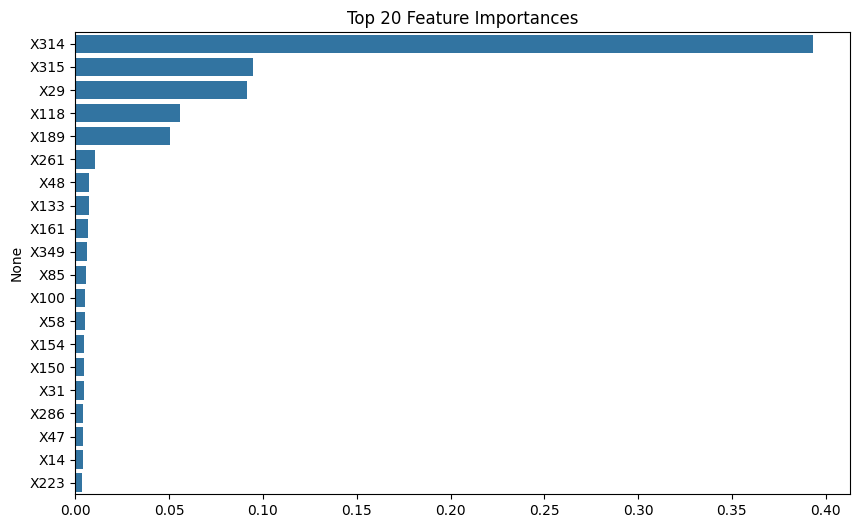

Top features to focus on for optimization: ['X314', 'X315', 'X29', 'X118', 'X189']


In [14]:
# Plot feature importance
feature_importances = model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_idx][:20], y=X_train.columns[sorted_idx][:20])
plt.title("Top 20 Feature Importances")
plt.show()

# Suggest which features (manufacturing parameters) to optimize
top_features = X_train.columns[sorted_idx][:5]
print(f"Top features to focus on for optimization: {list(top_features)}")
